# Machine Learning on Stock Time Series Data : Ebay and Yahoo

### Exploratory Data Analysis

We'll deal with stock market prices that fluctuate over time. In this project we've got historical prices from two tech companies (Ebay and Yahoo) in the DataFrame prices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/prices.csv", parse_dates=["date"], index_col="date")

EBAY = df[df["symbol"].isin(["EBAY"])].drop(["symbol","volume"], axis=1).rename(columns={"close": "EBAY"})
YHOO = df[df["symbol"].isin(["YHOO"])].drop(["symbol","volume"], axis=1).rename(columns={"close": "YHOO"})
prices = pd.concat([EBAY, YHOO], axis=1)
prices.head()

,EBAY,YHOO
date,,
2010-01-04,23.900000,17.100000
2010-01-05,23.650000,17.230000
2010-01-06,23.500000,17.170000
2010-01-07,23.229998,16.700001
2010-01-08,23.509999,16.700001


Let us visualize the raw data for the two companies, through the line chart. It will show the general trend of the price movements of both companies

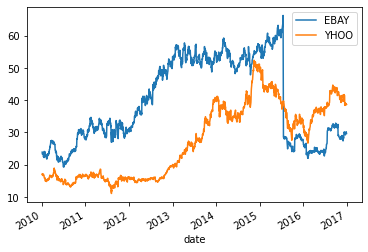

In [2]:
# Plot the raw values over time
prices.plot()
plt.show()

Now let us generate a scatter plot showing how the values for each company compare with one another. This is a way of using cluster analysis to understand where two companies form clusters and how close the clusters are.

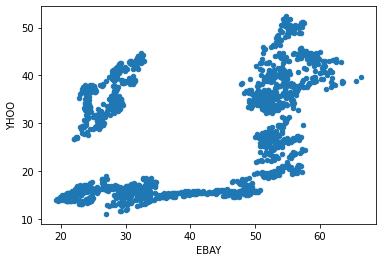

In [3]:
# Scatterplot with one company per axis
prices.plot.scatter("EBAY", "YHOO")
plt.show()

Finally, let us add in a "time" dimension to our scatter plot so that we can see how this relationship changes over time.

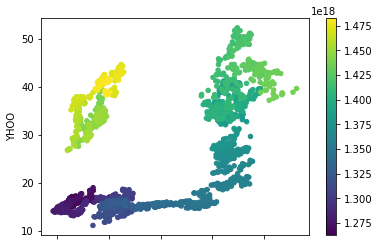

In [5]:
# Scatterplot with color relating to time
prices.plot.scatter('EBAY', 'YHOO', c=prices.index, 
                    cmap=plt.cm.viridis, colorbar=True)
plt.show()

Let us see if there is any missing values in the dataset

In [6]:
# Count the missing values of each time series
missing_values = prices.isnull().sum()
print(missing_values)

EBAY    0
YHOO    0
dtype: int64
